In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.mixture import GaussianMixture

import re
import json

from transformers import BertTokenizer, BertModel
import torch
from torch.nn.utils.rnn import pad_sequence


In [173]:
df = pd.read_csv(r'C:\\Data\\Pet Parser HH\\combined_data.csv')

In [174]:
df.head(5)

name                     salary  \
0                  Аналитик данных                        NaN   
1                         Аналитик   45000 до 60000 ₽ на руки   
2                   Инженер данных                        NaN   
3                         Аналитик                        NaN   
4  Аналитик данных в отделе закупа  70000 до 110000 ₽ на руки   

                            experience                           time  \
0      Требуемый опыт работы: 1–3 года  Полная занятость, полный день   
1  Требуемый опыт работы: не требуется  Полная занятость, полный день   
2      Требуемый опыт работы: 1–3 года  Полная занятость, полный день   
3      Требуемый опыт работы: 1–3 года  Полная занятость, полный день   
4      Требуемый опыт работы: 1–3 года  Полная занятость, полный день   

                                             company      address  \
0                                        ООО PepsiCo       Москва   
1                                     ООО ТЕХНОТРЕЙД       Ростов   
2              ГКУ «Центр цифровой трансформации РТ»       Казань   
3  ТОО МИКРОФИНАНСОВАЯ ОРГАНИЗАЦИЯ SOFI FINANCE (...       Алматы   
4                                  DNS Головной офис  Владивосток   

                                                tags  \
0  ['Машинное обучение', 'Python', 'Прогнозирован...   
1  ['Анализ данных', 'Составление отчетности', 'М...   
2                                                 []   
3  ['SQL', 'Базы данных', 'Аналитика', 'Аналитиче...   
4  ['Грамотная речь', 'Деловая переписка', 'Монит...   

                                    hh_link          field  
0  https://odintsovo.hh.ru/vacancy/93552240   Data Analyst  
1  https://odintsovo.hh.ru/vacancy/92927407   Data Analyst  
2  https://odintsovo.hh.ru/vacancy/90862096  Data Engineer  
3  https://odintsovo.hh.ru/vacancy/93575894   Data Analyst  
4  https://odintsovo.hh.ru/vacancy/91685472   Data Analyst

In [175]:
df.shape

(2831, 9)

In [176]:
#проверим дубликаты
df.duplicated().sum()

199

In [177]:
#удалим дубликаты  и восстановим индексы
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(2632, 9)

In [178]:
#посмотрим сколько и каикх значений получается в названия вакансий
#  по результату вывода видно, что такой рзброс осложняет работу с аналитикой
# необходимо сгруппировать данные по полям
name_counter = Counter(df['name'])
len(name_counter)

1691

In [244]:
#создадим рабочую копию датасета для обработкиб удалим ненужные колонки для анализа
df_2 = df.copy()
df_2 = df_2.drop(['hh_link', 'field'], axis=1)
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632 entries, 0 to 2631
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        2632 non-null   object
 1   salary      582 non-null    object
 2   experience  2632 non-null   object
 3   time        2632 non-null   object
 4   company     2632 non-null   object
 5   address     2588 non-null   object
 6   tags        2632 non-null   object
dtypes: object(7)
memory usage: 144.1+ KB


In [245]:
#так как дальнейшая работа осложняется большим разбросом названий вакансий, необходимо обработать данные для дальнейшего анализа
#обработаем колонки с данными название и теги вакансий, которые содержат информацию.

df_2['tags']= df_2['tags'].apply(lambda x: str(x).replace('[','').replace(']','').replace("'", '').replace(',', '').lower())
df_2['name']= df_2['name'].apply(lambda x:str(x).replace ('/', '').replace('(', '').replace(')', '').replace('##', '').lower())

In [246]:
#посмотрим результат
df_2.sample(5)

name salary  \
581                   business analyst  бизнес-аналитик    NaN   
340                     продуктовый аналитик e-commerce    NaN   
2608  бизнес-аналитик бизнес-юнит непрерывное произв...    NaN   
1202                             маркетинговый аналитик    NaN   
2220                          site reliability engineer    NaN   

                           experience                                time  \
581   Требуемый опыт работы: 1–3 года  Полная занятость, удаленная работа   
340   Требуемый опыт работы: 1–3 года       Полная занятость, полный день   
2608   Требуемый опыт работы: 3–6 лет  Полная занятость, удаленная работа   
1202  Требуемый опыт работы: 1–3 года       Полная занятость, полный день   
2220   Требуемый опыт работы: 3–6 лет       Полная занятость, полный день   

                  company       address  \
581            Green Code        Москва   
340   Lucy in the Sky Inc        Москва   
2608            ООО ЦИФРА  Екатеринбург   
1202            NielsenIQ        Москва   
2220             Тинькофф         Санкт   

                                                   tags  
581                                                      
340   sql power bi анализ данных аналитика a/b тесты...  
2608  bpmn бизнес-анализ uml моделирование бизнес пр...  
1202                                                     
2220      linux python docker kubernetes ansible devops

In [247]:
#Основная проблема в нашем анализе - многообразие названий вакансий
name_counter = Counter(df_2['name'])
name_counter

Counter({'аналитик данных': 44,
         'аналитик': 63,
         'инженер данных': 5,
         'аналитик данных в отделе закупа': 1,
         'architect  senior system analyst обработка данных экосистемы': 1,
         'data analyst  аналитик данных': 4,
         'junior аналитик данных': 1,
         'аналитик данных веб-аналитика': 1,
         'младший аналитиканалитик': 1,
         'ведущий аналитик данных': 2,
         'маркетолог-аналитик \\ аналитик данных': 1,
         'аналитик данных маркетинг': 1,
         'системный аналитик': 94,
         'экономист-аналитик': 11,
         'финансовый аналитик': 24,
         'бизнес аналитик': 1,
         'аналитик bi': 4,
         'бизнес-аналитик': 63,
         'аналитик данных  стажер': 1,
         'аналитик системный аналитик': 1,
         'редактор-аналитик': 1,
         'аналитик crm': 2,
         'аналитик рынков': 1,
         'младший аналитик': 4,
         'старший аналитик': 2,
         'data analyst': 45,
         'экономист анали

In [248]:
#так как данные двуязычные + вариативные названия вакансий, почистим данным колонки name для упрощения дальнейшего анализа.
#предварительно нам надо получить 4-5 названий вакансий, вероятно сделать кластеризацию.

def clean_job_title(name_str):
    job_titles = ['аналитик данных', 'data scientist', 'data engineer', 'инженер', 'системный аналитик', 'engineer', 'data analyst', 'дата аналитик', 'бизнес аналитик']
    
    for title in job_titles:
        if title in name_str.lower():
            return title
    
    return name_str

    
    
df_2['name']= df_2['name'].apply(clean_job_title)
    

In [249]:
#посомтрим результат предварительно очистки
name_counter = Counter(df_2['name'])
len(name_counter)

998

*Предвариетльная очистка уже уменьшила список названий в два раза*

In [250]:
#посмотрим еще раз на данные и очистим явный мусор, так как модели кластеризации могут сильно регировать на явные выбросы
#соберем явный список исключений
excluded_job_titles = [
    'таргетолог', 'таргетолог вк', 'middlesenior php developer', 'marketplace manager',
    'crm-маркетолог', 'sales manager', 'специалист по контекстной рекламе google ads',
    'senior ios разработчик', 'менеджер по работе с поставщиками байер',
    'back-end developer', 'аккаунт-менеджер', 'digital аккаунт-менеджер digital manager project manager',
    'junior pre-middle vue.js developer', 'intern seo-специалист начинающий специалист по поисковому продвижению',
    'специалист по контекстной рекламе ppc-специалист', 'тестировщик есс',
    'front-end developer vue.js', 'it-рекрутер', 'менеджер по продажам удаленно',
    'менеджер по продажам по работе с клиентами в ит-компанию', 'менеджер по закупкам',
    'помощник котельной без опыта', 'помощникстажёр мастера по ремонту оборудования',
    'помощник мастера без опыта', 'ученик мастера по ремонту бытовой техники',
    'помощник мастера на разборку техники', 'личный ассистент руководителя персональный помощник',
    'начинающий специалист нa ремонт', 'помощник мастера', 'помощник мастера в мастерскую без опыта',
    'java разработчик продукт втб', 'разработчик go', 'начинающий специалист по сборке и ремонту техники',
    'помощник в мастерскую', 'мастер по ремонту бытовой техники',
    'начинающий специалист в отдел бытовой техники', 'помощник по ремонту техники',
    'помощник мастераразнорабочий', 'рабочий сервисного центра', 
    'разработчик backend [.net c# || python]', 'influencer marketing manager',
    'ведущий специалист по продажам корпоративным клиентам b2b', 'key account manager',
    'quantitative trader'
]

# отфилттруем датасет и проверим результат
df_2 = df_2[~df_2['name'].str.lower().isin(excluded_job_titles)]
df_2 = df_2.reset_index(drop=True)
name_counter= Counter(df_2['name'])
len(name_counter)


961

**так как названия вакансий очень разные, надо созадть метки класса для каждой вакансии**
- предварительно, я вижу 4 класса, попробуем двумя способами откластеризовать данные - только по имени, и по вектору имя + теги. 
- второй вариант  -отказываюсь, так как 1. но во всех вакансиях есть теги, 2. теги искажают первичное название вакансии, которые подразумевал работодатель + тут не стоит задача глубоко анализа рынка.

Для оценки кластеров будем использовать 
- визуализацию через метод PCA
- метрики
- Инерция отражает сумму квадратов расстояний от каждой точки до центроида ее кластера
- Коэффициент силуэта измеряет насколько объект похож на свой кластер по сравнению с другими кластерами
- Adjusted Rand index сравнивает пары объектов и оценивает, насколько они помещены в один и тот же кластер в исходных данных и после кластеризации.

In [251]:
#как baseline оппробуем самый простой способ с помощью KMeans
#KMeans самый простой, легкий, интерпретируемый метод, но с минусами - часто ему не удается интерпретировать реальные данные

#данные преодобработаем и подадим в кластеризацию

# Предобработка данных
stop_words = set(stopwords.words('russian'))

# Инициализация объектов для токенизации и лемматизации
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

# Определение функции для токенизации и лемматизации текста
def tokenize_and_lemmatize(text):
    if text is not None:
        tokens = tokenizer.tokenize(text.lower())
        lemmas = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmas)
    else:
        return ''
# Применение токенизации и лемматизации к столбцу 'name'
df_2['name'] = df_2['name'].apply(tokenize_and_lemmatize)
#df_2['tags'] = df_2['tags'].apply(tokenize_and_lemmatize)
#df_2['combined'] = df_2['name'] + ' ' + df_2['tags']

# Преобразование текста в векторы TF-IDF для всех столбцов
vectorizer = CountVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(df_2['name'])

# Создание и обучение модели KMeans
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)

# Получение меток кластеров для каждого примера
labels = kmeans.labels_

# Добавление предсказанных кластеров в исходные данные
df_2['Km_predicted_cluster'] = labels

#Оценка метрик

# вычисление инерции кластеров
inertia = kmeans.inertia_
print(f'Inertia: {inertia}')

# вычисление коэффициента силуэта
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
print(f'Silhouette Score: {silhouette_score}')

# вычисление adjusted Rand index
rand_index = metrics.adjusted_rand_score(df_2['Km_predicted_cluster'], labels)
print(f'Adjusted Rand Index: {rand_index}')

# вывод результатов
df_2.head(5)


Inertia: 4039.311135711207
Silhouette Score: 0.27563833459877296
Adjusted Rand Index: 1.0


name                     salary  \
0  аналитик данных                        NaN   
1         аналитик   45000 до 60000 ₽ на руки   
2          инженер                        NaN   
3         аналитик                        NaN   
4  аналитик данных  70000 до 110000 ₽ на руки   

                            experience                           time  \
0      Требуемый опыт работы: 1–3 года  Полная занятость, полный день   
1  Требуемый опыт работы: не требуется  Полная занятость, полный день   
2      Требуемый опыт работы: 1–3 года  Полная занятость, полный день   
3      Требуемый опыт работы: 1–3 года  Полная занятость, полный день   
4      Требуемый опыт работы: 1–3 года  Полная занятость, полный день   

                                             company      address  \
0                                        ООО PepsiCo       Москва   
1                                     ООО ТЕХНОТРЕЙД       Ростов   
2              ГКУ «Центр цифровой трансформации РТ»       Казань   
3  ТОО МИКРОФИНАНСОВАЯ ОРГАНИЗАЦИЯ SOFI FINANCE (...       Алматы   
4                                  DNS Головной офис  Владивосток   

                                                tags  Km_predicted_cluster  
0  машинное обучение python прогнозирование спрос...                     2  
1  анализ данных составление отчетности мониторин...                     2  
2                                                                        3  
3  sql базы данных аналитика аналитическое мышлен...                     2  
4  грамотная речь деловая переписка мониторинг ры...                     2

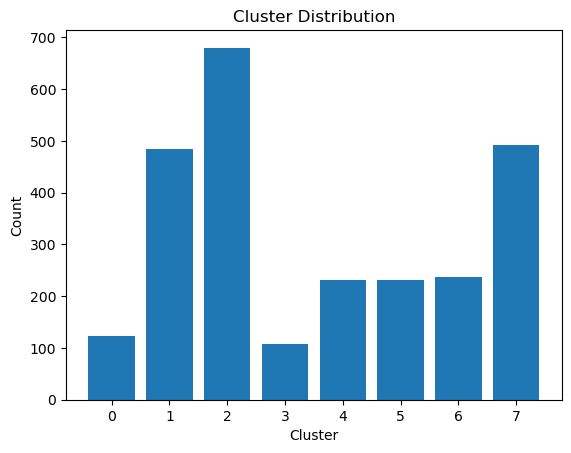

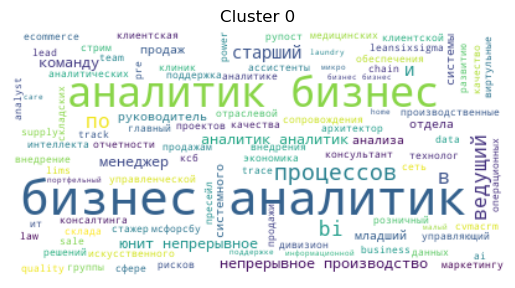

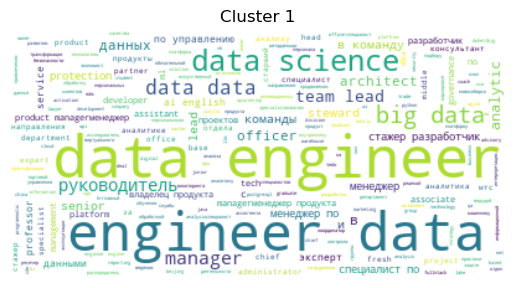

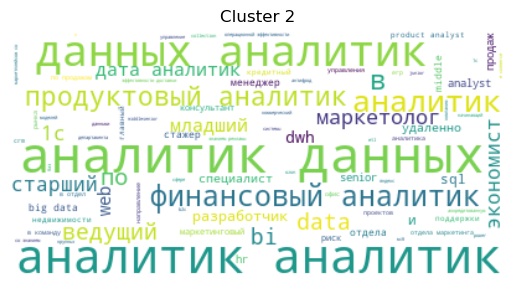

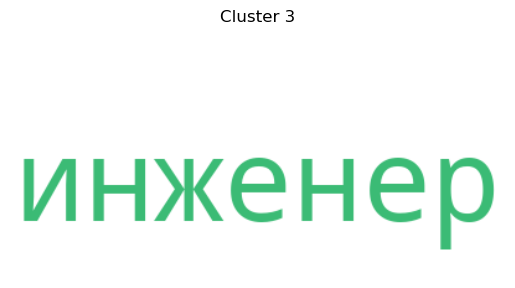

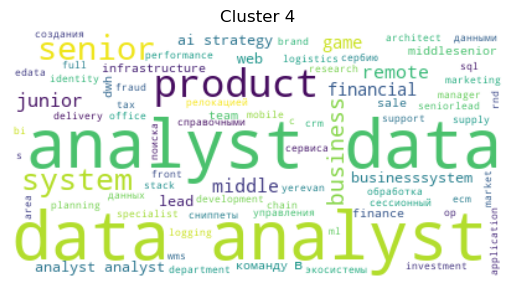

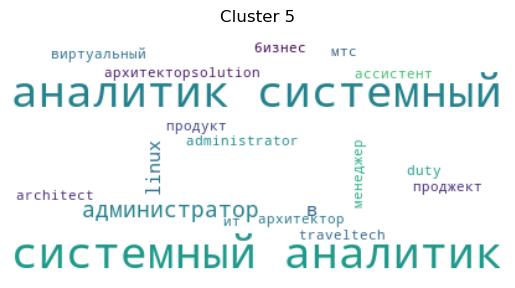

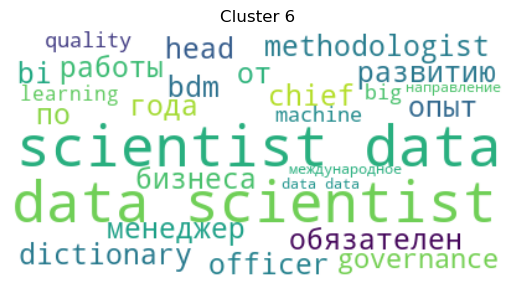

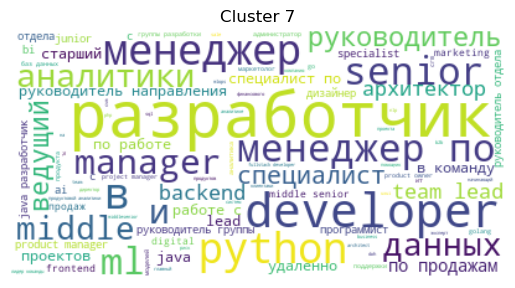

In [252]:
#визуализуализируем полученный результат и покажем в облаке слова для каждого кластера

clusters = kmeans.labels_
# Визуализация с помощью столбчатой диаграммы
cluster_counts = np.bincount(clusters)
plt.bar(range(len(cluster_counts)), cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.show()

# Визуализация с помощью облака слов
clusters = df_2['Km_predicted_cluster'].tolist()

# Создаем словарь, где ключами являются метки кластеров, а значениями - списки слов в каждом кластере
cluster_words = {}
for cluster in set(clusters):
    cluster_words[cluster] = []

# Заполняем словарь словами из каждого кластера
for i in range(len(df_2)):
    cluster = clusters[i]
    name = df_2.loc[i, 'name']
    cluster_words[cluster].append(name)

# Создаем облако слов для каждого кластера
for cluster in set(clusters):
    wordcloud = WordCloud(background_color='white').generate(' '.join(cluster_words[cluster]))

    # Отображаем облако слов
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster}')
    plt.show()


*Так как у нас двуязычные данные, счетчик и модель их видят отдельным кластером, я увеличиваю количество кластеров для выделения в отдельный кластер и потом ручннм методом перенесем их в один кластер*

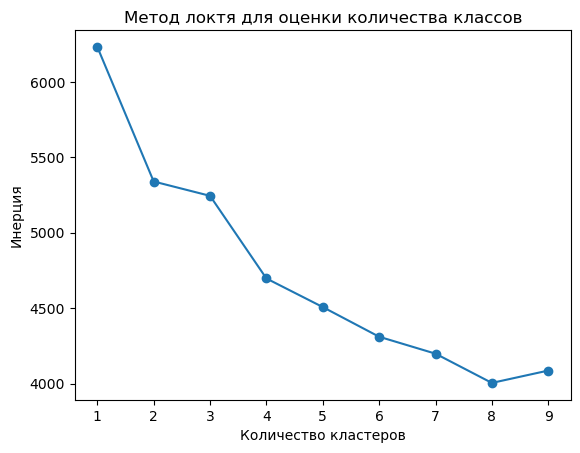

In [253]:
#попробуем определить методом локтя количество кластеров
# может быть количество кластеров надо увеличить 

# создадим список для инерции (суммы квадратов расстояний от каждой точки до ближайшего центроида)
inertia = []

# азададим диапазон количества кластеров для проверки
k_range = range(1, 10)


df_2['name'] = df_2['name'].apply(tokenize_and_lemmatize)
vectorizer = CountVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(df_2['name'])

# Выполнение KMeans для разного количества кластеров и сохранение инерции
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X) 
    inertia.append(kmeans.inertia_)

# Построение графика метода локтя
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя для оценки количества классов')
plt.show()


- Метод локтя не дает однозначного ответа, есть *переломы* в точках 2, 4  и 8
- Если оценивать по метрикам, в частности метрике внутрикластерного расстояния, лучшая метрика на 8 кластерах, что подтверждается облаком слов
- проверим еще результат визуально

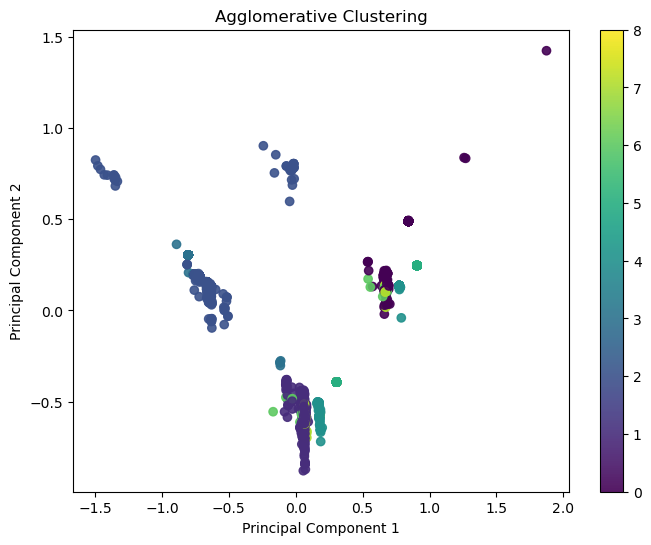

In [254]:
# Уменьшение размерности данных до 2-х компонент с помощью PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
labels= kmeans.labels_
# Визуализация кластеризации
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.9)
plt.title('Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()



Согласно интуиции как минимум есть следующие классы: 
- Data Analyst
- Data Scientist
- Data Engineer
- System Analyst
- Other Analysts
- DevOps (разрабочики)

In [255]:
#применим другой алгоритм  - алгоритм иерархической кластеризации
#попробуем разное количество классов и последующую визаулизацию результата


df_2['name'] = df_2['name'].apply(tokenize_and_lemmatize)
vectorizer = CountVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(df_2['name'])

# Создание и обучение модели Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=8)
agg_clustering.fit(X.toarray())

# Получение меток кластеров для каждого примера
labels = agg_clustering.labels_

# Добавление предсказанных кластеров в исходные данные
df_2['predicted_cluster_agg'] = labels

#оценка метрик

# вычисление коэффициента силуэта
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
print(f'Silhouette Score: {silhouette_score}')

# вычисление adjusted Rand index
rand_index = metrics.adjusted_rand_score(df_2['predicted_cluster_agg'], labels)
print(f'Adjusted Rand Index: {rand_index}')


# Вывод результатов
df_2.sample(5)


Silhouette Score: 0.29390327519927895
Adjusted Rand Index: 1.0


name  \
484                        аналитик в сфере образования   
1909  pricing and ancillary revenue specialist специ...   
711                                       data engineer   
1025                                       data analyst   
1240                                     data scientist   

                                  salary                           experience  \
484            90000 ₽ до вычета налогов       Требуемый опыт работы: 3–6 лет   
1909  92000 до 92000 ₽ до вычета налогов  Требуемый опыт работы: не требуется   
711                                  NaN       Требуемый опыт работы: 3–6 лет   
1025                                 NaN       Требуемый опыт работы: 3–6 лет   
1240                                 NaN       Требуемый опыт работы: 3–6 лет   

                               time                              company  \
484   Полная занятость, полный день  Образовательный Фонд Талант и успех   
1909  Полная занятость, полный день                   ООО Северный Ветер   
711   Полная занятость, полный день                             Тинькофф   
1025  Полная занятость, полный день                             Go Ahead   
1240  Полная занятость, полный день            АО Промышленные инновации   

     address                                               tags  \
484     Сочи                                                      
1909  Москва  marketing analysis analytical skills product m...   
711   Казань  sql hadoop ms sql работа с базами данных ms sq...   
1025  Москва                                                      
1240  Москва  data analysis анализ данных аналитика data sci...   

      Km_predicted_cluster  predicted_cluster_agg  
484                      2                      2  
1909                     7                      1  
711                      1                      3  
1025                     4                      4  
1240                     6                      0

*Здесь так же лучшая метрика получается на 8 кластерах*

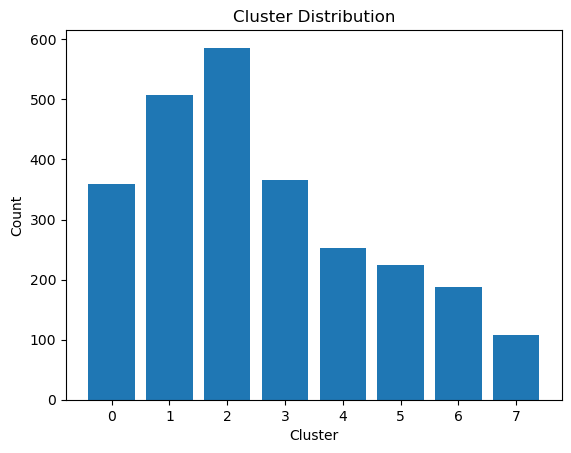

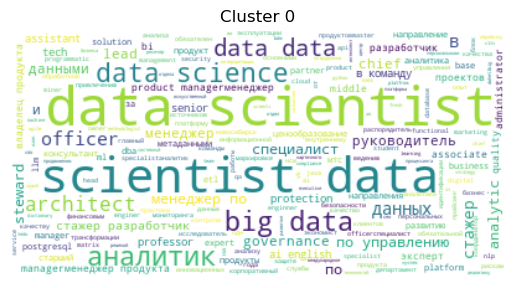

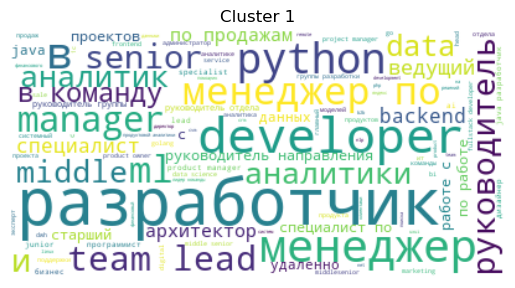

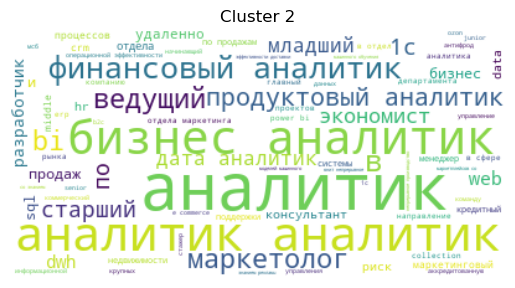

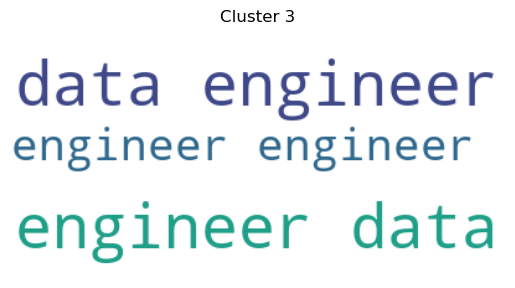

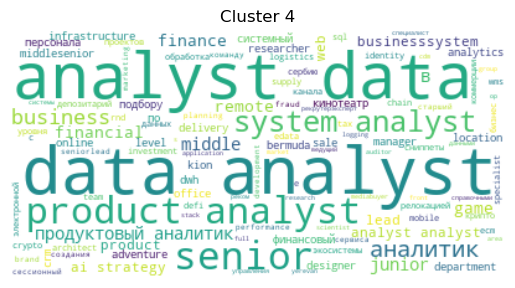

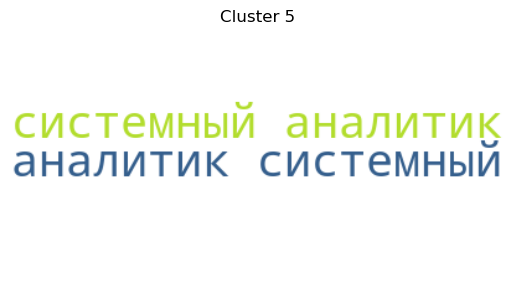

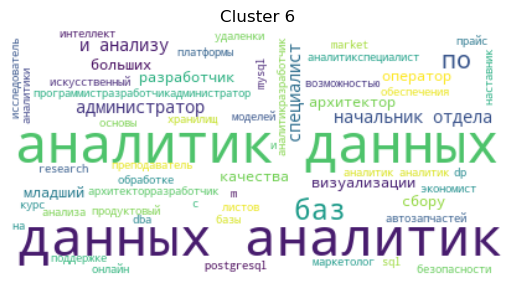

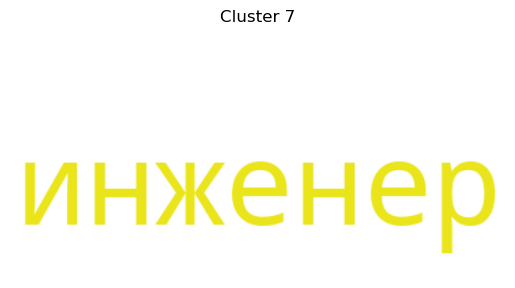

In [256]:
#визуализируем так же результат с помощью облака слов и посмотрим результат

clusters = agg_clustering.labels_
# Визуализация с помощью столбчатой диаграммы
cluster_counts = np.bincount(clusters)
plt.bar(range(len(cluster_counts)), cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.show()

# Визуализация с помощью облака слов
clusters = df_2['predicted_cluster_agg'].tolist()

# Создаем словарь, где ключами являются метки кластеров, а значениями - списки слов в каждом кластере
cluster_words = {}
for cluster in set(clusters):
    cluster_words[cluster] = []

# Заполняем словарь словами из каждого кластера
for i in range(len(df_2)):
    cluster = clusters[i]
    name = df_2.loc[i, 'name']
    cluster_words[cluster].append(name)

# Создаем облако слов для каждого кластера
for cluster in set(clusters):
    wordcloud = WordCloud(background_color='white').generate(' '.join(cluster_words[cluster]))

    # Отображаем облако слов
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster}')
    plt.show()


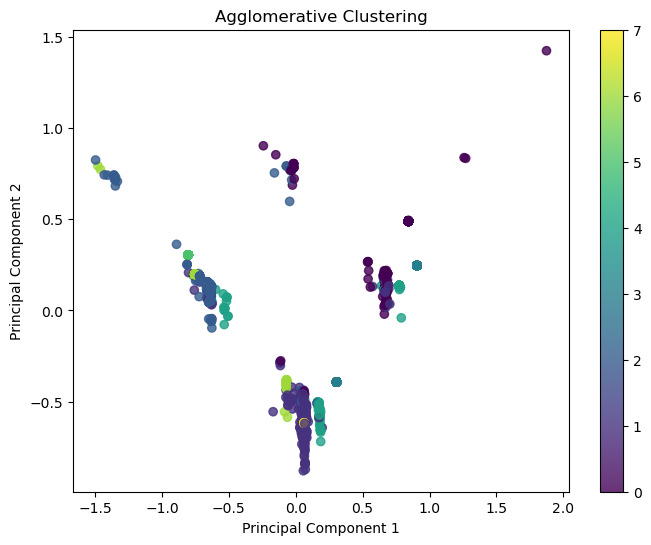

In [257]:
#попробуем визулизировать полученные кластеры

# Уменьшение размерности данных до 2-х компонент с помощью PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
labels= agg_clustering.labels_
# Визуализация кластеризации
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.8)
plt.title('Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()


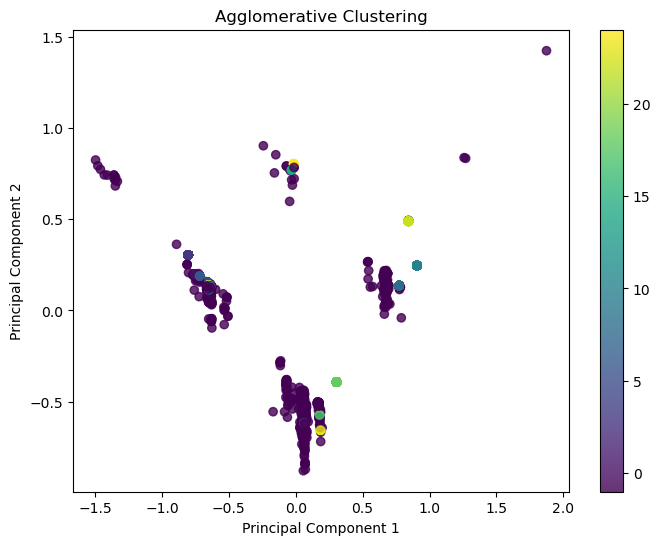

In [258]:
#попробуем еще один алгорим DBSCAN, который сам разделяет на количество кластеров, учитывая плотность распределения. 

df_2['name'] = df_2['name'].apply(tokenize_and_lemmatize)
vectorizer = CountVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(df_2['name'])

# Создание и обучение модели DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)

# Получение меток кластеров для каждого примера
dbscan_labels = dbscan.labels_

# Добавление предсказанных кластеров в исходные данные
df_2['DBSCAN_predicted_cluster'] = dbscan_labels

# Уменьшение размерности данных до 2-х компонент с помощью PCA и посомтрим сразу результат
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
labels= dbscan.labels_
# Визуализация кластеризации
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.8)
plt.title('Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [259]:
dbscan_labels

array([ 0,  1,  2, ..., 22,  3, 18], dtype=int64)

DBSCAN при переборе разных параметров не апроксимирует данные как Kmeans, относит данные либо к одному классу, либо к выбросам

В модели DBSCAN (Density-Based Spatial Clustering of Applications with Noise) кластер -1 обычно означает шумовые точки или выбросы. Когда алгоритм DBSCAN не может присвоить точку ни одному из существующих кластеров, она получает метку -1 и считается выбросом. Таким образом, точки с меткой -1 не принадлежат ни одному из кластеров, и их можно рассматривать как шумовые данные или выбросы. (НО в нашем случае это не шум в таких количествах)

Кластер -1 в DBSCAN указывает на то, что эти точки не удовлетворяют условиям определения кластеров в рамках данного алгоритма. Важно учитывать и анализировать такие выбросы при интерпретации результатов кластеризации.

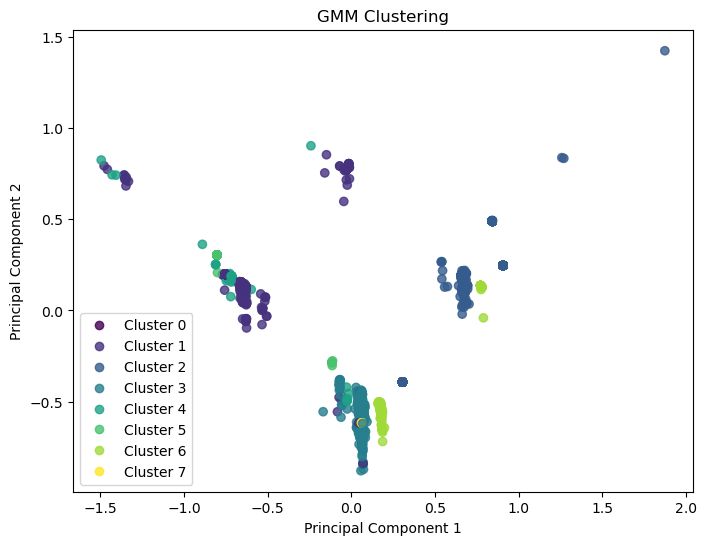

In [260]:
#попробуем модель, основанную на гаусовсском распределении

df_2['name'] = df_2['name'].apply(tokenize_and_lemmatize)
vectorizer = CountVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(df_2['name'])

gmm = GaussianMixture(n_components=8).fit(X.toarray())
gmm_labels = gmm.predict(X.toarray())


# Добавление предсказанных кластеров в исходные данные
df_2['GMM_predicted_cluster'] = gmm_labels

# Уменьшение размерности данных до 2-х компонент с помощью PCA и посомтрим сразу результат
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
labels= gmm_labels
# Визуализация кластеризации
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.8)
plt.title('GMM Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'])
plt.show()

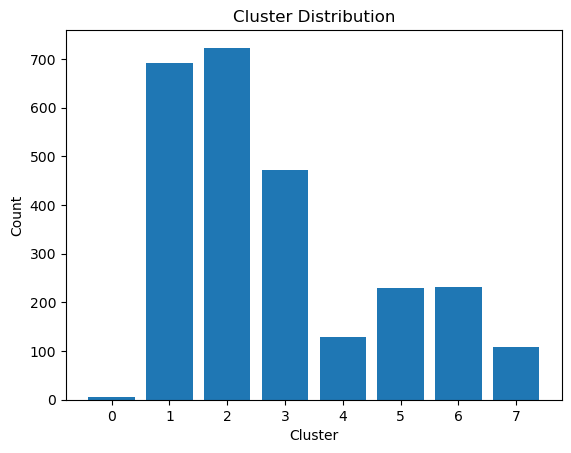

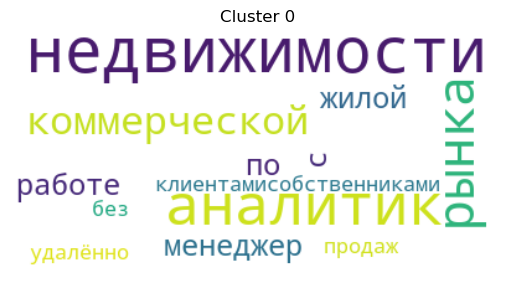

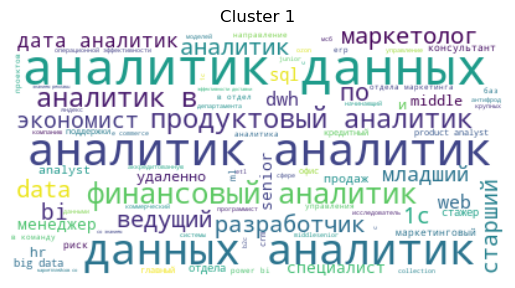

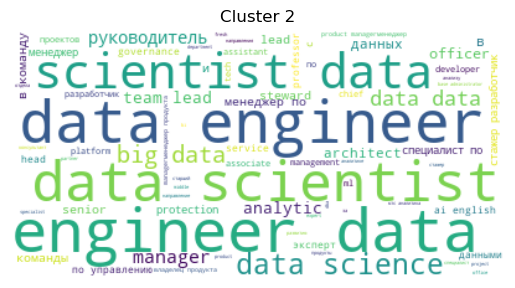

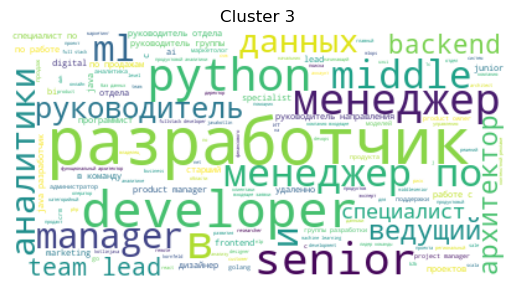

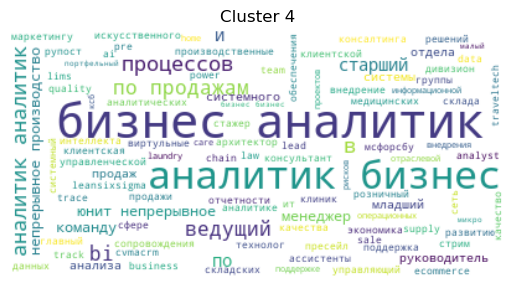

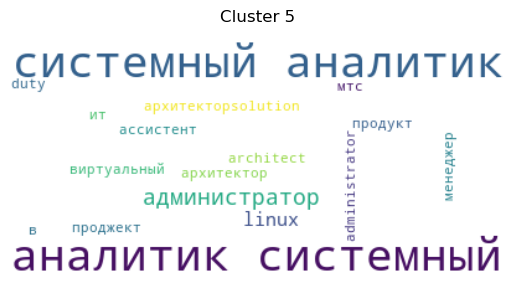

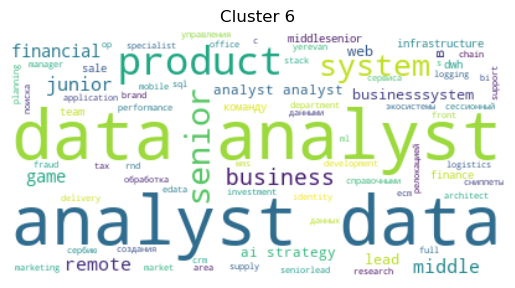

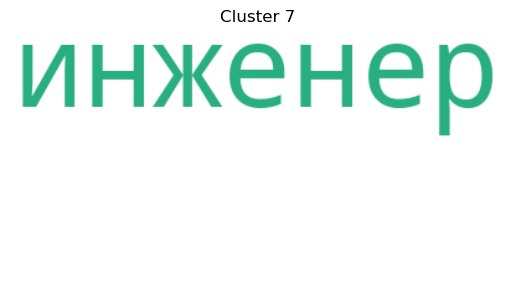

In [261]:
#визуализируем так же результат с помощью облака слов и посмотрим результат

clusters = gmm_labels
# Визуализация с помощью столбчатой диаграммы
cluster_counts = np.bincount(clusters)
plt.bar(range(len(cluster_counts)), cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.show()

# Визуализация с помощью облака слов
clusters = df_2['GMM_predicted_cluster'].tolist()

# Создаем словарь, где ключами являются метки кластеров, а значениями - списки слов в каждом кластере
cluster_words = {}
for cluster in set(clusters):
    cluster_words[cluster] = []

# Заполняем словарь словами из каждого кластера
for i in range(len(df_2)):
    cluster = clusters[i]
    name = df_2.loc[i, 'name']
    cluster_words[cluster].append(name)

# Создаем облако слов для каждого кластера
for cluster in set(clusters):
    wordcloud = WordCloud(background_color='white').generate(' '.join(cluster_words[cluster]))

    # Отображаем облако слов
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster}')
    plt.show()


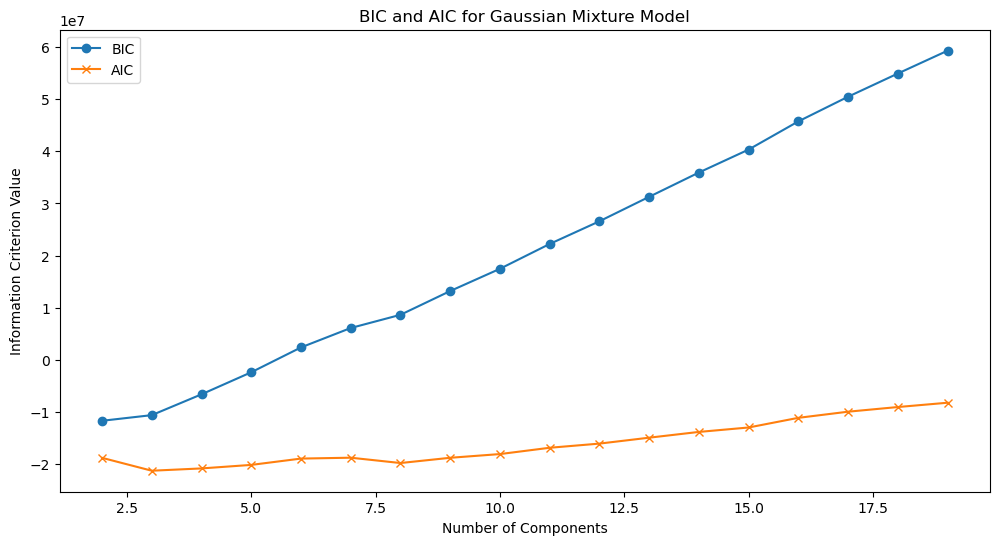

In [206]:
#найдем количество кластеров которые модель определяет 

# создаем список для хранения значений BIC и AIC
bic_values = []
aic_values = []

# определяем диапазон количества кластеров
n_components_range = range(2, 20)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X.toarray()) 
    
    bic_values.append(gmm.bic(X.toarray()))
    aic_values.append(gmm.aic(X.toarray()))

# Строим график BIC и AIC
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, bic_values, label='BIC', marker='o')
plt.plot(n_components_range, aic_values, label='AIC', marker='x')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion Value')
plt.title('BIC and AIC for Gaussian Mixture Model')
plt.legend()
plt.show()


*Метрики BIC AIC  определяем по минимальному значению. Где то тоже в районе 8 есть *прогиб*  в количестве компонентов. Однако очевидно, что модель готова увеличивать количество кластеров и далее, то есть данные не апроксимируются качественно на количестве кластеров до 10*

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


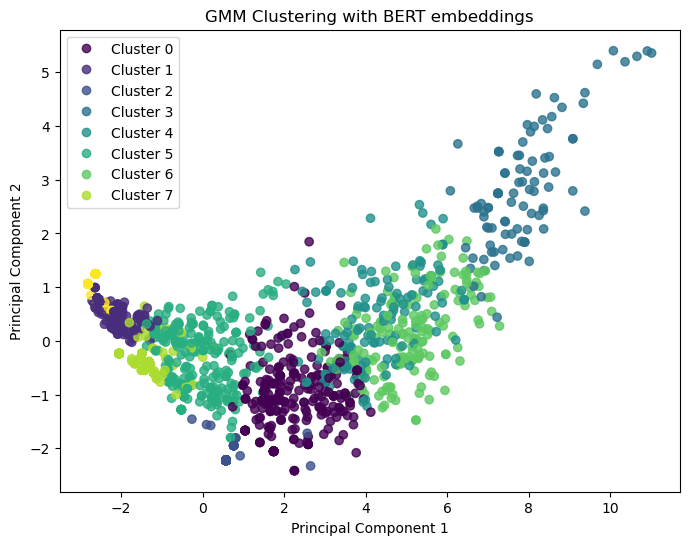

In [262]:
#обработка текста с помощью BERT  и кластеризаия для решения вопроса с языками
#возьмем многоязычную модель, но так как тексты небольшие, не ожиадется значительного увеличения результата, тем нее менее интересно оценить результат с расздением на языки

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

def tokenize_and_encode(text):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    return input_ids

df_2['name_encoded'] = df_2['name'].apply(tokenize_and_encode)

# Преобразование текста в эмбеддинги с помощью BERT
X_bert = pad_sequence([torch.LongTensor(ids) for ids in df_2['name_encoded']], batch_first=True)#выравнивание длины списковс заполнителем (нули)
with torch.no_grad():
    outputs = model(X_bert)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Усреднение эмбеддингов слов для получения представления всего текста

gmm_bert = GaussianMixture(n_components=9).fit(embeddings.numpy())
gmm_labels_bert = gmm_bert.predict(embeddings.numpy())

# Добавление предсказанных кластеров в исходные данные
df_2['GMM_predicted_cluster_BERT'] = gmm_labels_bert

pca_bert = PCA(n_components=2)
X_pca_bert = pca_bert.fit_transform(embeddings.numpy())

plt.figure(figsize=(8, 6))
scatter_bert = plt.scatter(X_pca_bert[:, 0], X_pca_bert[:, 1], c=gmm_labels_bert, cmap='viridis', alpha=0.8)
plt.title('GMM Clustering with BERT embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter_bert.legend_elements()[0], labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'])
plt.show()


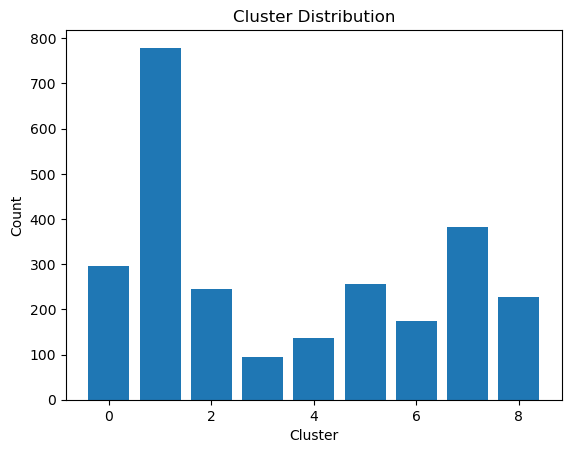

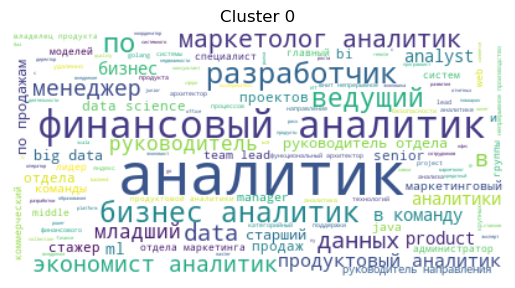

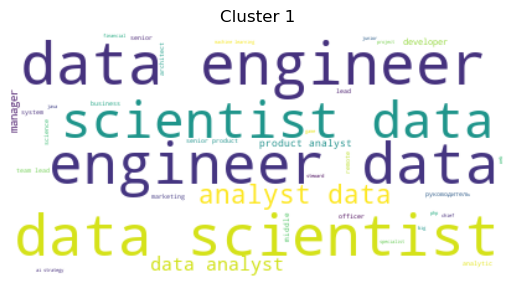

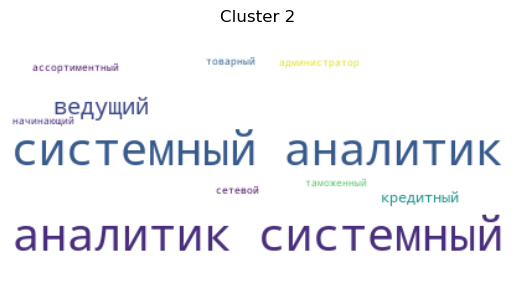

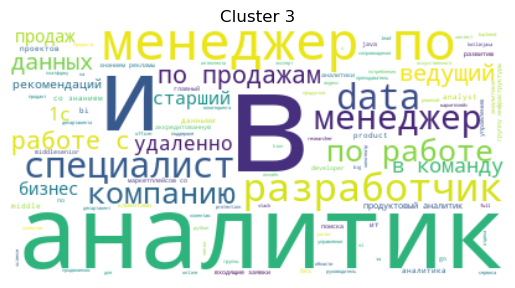

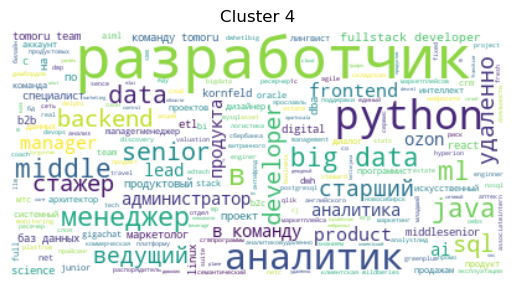

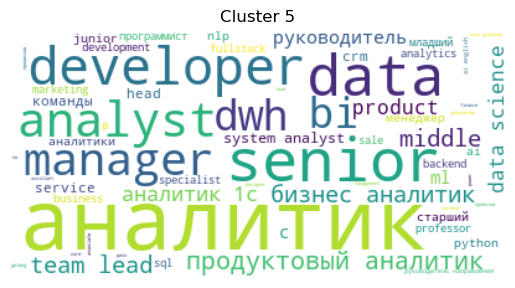

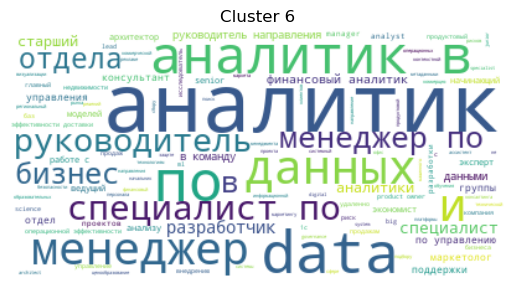

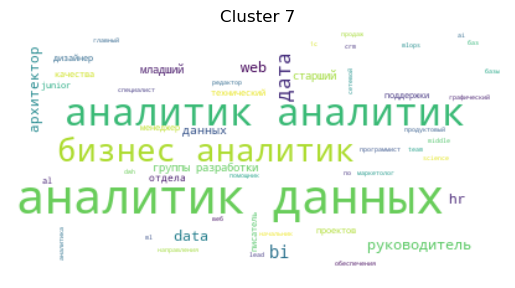

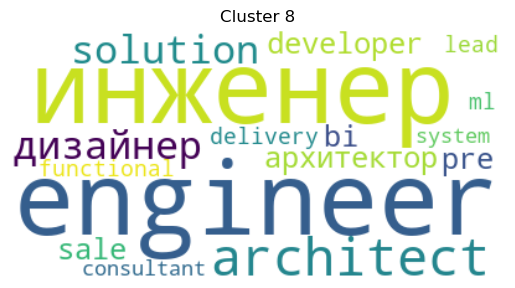

In [263]:
#визуализируем так же результат с помощью облака слов и посмотрим результат

clusters = gmm_labels_bert
# Визуализация с помощью столбчатой диаграммы
cluster_counts = np.bincount(clusters)
plt.bar(range(len(cluster_counts)), cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.show()

# Визуализация с помощью облака слов
clusters = df_2['GMM_predicted_cluster_BERT'].tolist()

# Создаем словарь, где ключами являются метки кластеров, а значениями - списки слов в каждом кластере
cluster_words = {}
for cluster in set(clusters):
    cluster_words[cluster] = []

# Заполняем словарь словами из каждого кластера
for i in range(len(df_2)):
    cluster = clusters[i]
    name = df_2.loc[i, 'name']
    cluster_words[cluster].append(name)

# Создаем облако слов для каждого кластера
for cluster in set(clusters):
    wordcloud = WordCloud(background_color='white').generate(' '.join(cluster_words[cluster]))

    # Отображаем облако слов
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster}')
    plt.show()


*Как и предполагалось для таких маленьких текстов Bert сложная модель и не отрабатывает корректную кластеризацию*

**Для дальнейшей работы возьму кластеризацию, выполненную методом Kmeans  на 8 кластерах***

In [264]:
#проверяем количество колонок
df_2.columns

Index(['name', 'salary', 'experience', 'time', 'company', 'address', 'tags',
       'Km_predicted_cluster', 'predicted_cluster_agg',
       'DBSCAN_predicted_cluster', 'GMM_predicted_cluster', 'name_encoded',
       'GMM_predicted_cluster_BERT'],
      dtype='object')

In [265]:
cluster_names = {
    0: 'Business Analyst',
    1: 'Data Engineer',
    2: 'Data Analyst',
    3: 'Data Engineer',
    4: 'Data Analyst',
    5: 'System Analyst',
    6: 'Data Scientist',
    7: 'Data DevOps'
}

# замена номеров кластеров на их названия
df_2['Km_predicted_cluster'] = df_2['Km_predicted_cluster'].map(cluster_names)
# удаление ненужных столбцов первичной кластеризации 
df_2= df_2.drop(['DBSCAN_predicted_cluster', 'predicted_cluster_agg','GMM_predicted_cluster', 'name_encoded',
       'GMM_predicted_cluster_BERT'], axis = 1)

# вывод результатов с названиями кластеров
df_2.sample(5)

name            salary                       experience  \
739   продуктовый аналитик               NaN  Требуемый опыт работы: 1–3 года   
1446        data scientist               NaN   Требуемый опыт работы: 3–6 лет   
157        аналитик данных  130000 ₽ на руки  Требуемый опыт работы: 1–3 года   
1392          data analyst    4000 $ на руки   Требуемый опыт работы: 3–6 лет   
1368      category manager               NaN   Требуемый опыт работы: 3–6 лет   

                                    time  \
739   Полная занятость, удаленная работа   
1446       Полная занятость, полный день   
157        Полная занятость, полный день   
1392       Полная занятость, полный день   
1368       Полная занятость, полный день   

                                           company address  \
739                      билайн: ИТ, Data, Digital  Москва   
1446                           АО ТЕКОН-Инжиниринг  Москва   
157                                       KONNEKTU  Москва   
1392                                        Wanted  Москва   
1368  Novabev Group. Алкогольное направление. Офис  Москва   

                                                   tags Km_predicted_cluster  
739                 яндекс.метрика google analytics sql         Data Analyst  
1446                    python tensorflow pytorch keras       Data Scientist  
157   sql python работа с базами данных анализ данны...         Data Analyst  
1392                                                            Data Analyst  
1368  ms excel trade marketing английский язык анали...          Data DevOps

In [266]:
#проверим полученный результат
df_2['Km_predicted_cluster'].value_counts()

Data Analyst        911
Data Engineer       593
Data DevOps         493
Data Scientist      237
System Analyst      231
Business Analyst    123
Name: Km_predicted_cluster, dtype: int64

В данной работе не используется векторизация колонки tags, так как это может привести к переопределению вакансии по skills +  в ряде вакансии даныее отсутствуют, поэтому задача кластеризации была выполнена исключительно по данным оригинальных названий, без учета частоты повторения (так как это повлияет на результат)

In [267]:
#оптимизируем внешний вид таблицы
cols = df_2.columns.tolist()
cols = cols[-1:] + cols[1:-1] + cols[:1]
df_2 = df_2[cols]
df_2 = df_2.rename(columns={df_2.columns[0]: 'field'})


In [268]:
df_2['field'].value_counts()

Data Analyst        911
Data Engineer       593
Data DevOps         493
Data Scientist      237
System Analyst      231
Business Analyst    123
Name: field, dtype: int64

Обработаем колонку с зарплатами

In [269]:
salary_counter = Counter(df_2['salary'])
len(salary_counter), salary_counter

(284,
 Counter({nan: 2035,
          '45000 до 60000 ₽ на руки': 3,
          '70000 до 110000 ₽ на руки': 1,
          '50000 до 70000 ₽ на руки': 3,
          '130000 ₽ до вычета налогов': 4,
          '100000 до 140000 ₽ на руки': 3,
          '120000 ₽ на руки': 9,
          '50000 ₽ на руки': 6,
          '60000 до 100000 ₽ на руки': 4,
          '70000 ₽ на руки': 6,
          '51264 до 51264 ₽ до вычета налогов': 1,
          '90000 ₽ на руки': 8,
          '145000 ₽ на руки': 1,
          '75000 до 75000 ₽ на руки': 1,
          '170000 до 230000 ₽ на руки': 2,
          '100000 до 100000 ₽ на руки': 1,
          '47000 ₽ до вычета налогов': 1,
          '125000 до 125000 ₽ до вычета налогов': 1,
          '60000 до 80000 ₽ на руки': 4,
          '120000 ₽ до вычета налогов': 5,
          '50000 до 70000 ₽ до вычета налогов': 1,
          '60000 до 60000 ₽ на руки': 2,
          '35000 ₽ на руки': 2,
          '125000 ₽ до вычета налогов': 1,
          '130000 до 130000 ₽ на ру

In [270]:
#поставим цель - получить колонку со средней зарплатой (или начальной) где дана только одна цифра
#функция для обоаботки колонки с зарплатой
def process_salary(salary_str):
    if pd.isnull(salary_str):
        return 0
    
    salary_values = [int(s) for s in re.findall(r'\d+', salary_str)]

    if '₽' in salary_str:
        if 'до вычета налогов' in salary_str:
            if len(salary_values) == 1:
                return round(salary_values[0] * 0.87, 1)
            else:
                return round((sum(salary_values) / 2 )* 0.87, 1)
        else:
            if len(salary_values) == 1:
                return salary_values[0]
            elif len(salary_values) == 2:
                return round(sum(salary_values) / 2, 1)
    
    if '$' in salary_str:
        if 'до вычета налогов' in salary_str:
            if len(salary_values) == 1:
                return round(((salary_values[0] * 90)* 0.87), 1)
            else:
                return round((((sum(salary_values) / 2) * 90)* 0.87),1)
        else:
            if len(salary_values) == 1:
                return round(salary_values[0] * 90, 1)
            elif len(salary_values) == 2:
                return round((sum(salary_values) / 2) * 90, 1)
    
    if '₸' in salary_str:
        if 'до вычета налогов' in salary_str:
            if len(salary_values) == 1:
                return round((salary_values[0] * 0.20 )* 0.87, 1)
            else:
                return round(((sum(salary_values) / 2) * 0.20)* 0.87, 1)
        else:
            if len(salary_values) == 1:
                return round(salary_values[0] * 0.20, 1)
            elif len(salary_values) == 2:
                return round((sum(salary_values) / 2 )*0.20, 1)

    if "so'm" in salary_str:
        if 'до вычета налогов' in salary_str:
            if len(salary_values) == 1:
                return round((salary_values[0] * 0.0072)* 0.87, 1)
            else:
                return round(((sum(salary_values) / 2) * 0.0072)* 0.87, 1)
        else:
            if len(salary_values) == 1:
                return round(salary_values[0] * 0.0072, 1)
            elif len(salary_values) == 2:
                return round((sum(salary_values) / 2) *0.0072, 1)
    
    if '€' in salary_str:
        salary_values = [int(s) for s in re.findall(r'\d+', salary_str)]
        if 'до вычета налогов' in salary_str:
            if len(salary_values) == 1:
                return round((salary_values[0] * 100) * 0.87, 1)
            else:
                return (((sum(salary_values) / 2) * 100)* 0.87, 1)
        else:
            if len(salary_values) == 1:
                return salary_values[0] * 100
            elif len(salary_values) == 2:
                return (sum(salary_values) / 2) *100
            
    if 'Br' in salary_str:
        salary_values = [int(s) for s in re.findall(r'\d+', salary_str)]
        if 'до вычета налогов' in salary_str:
            if len(salary_values) == 1:
                return round((salary_values[0] * 28.47) * 0.87, 1)
            else:
                return (((sum(salary_values) / 2) * 28.47)* 0.87, 1)
        else:
            if len(salary_values) == 1:
                return salary_values[0] * 28.47
            elif len(salary_values) == 2:
                return (sum(salary_values) / 2) *28.47
    else:
        if len(salary_values) == 1:
                return salary_values[0]
        elif len(salary_values) == 2:
                return sum(salary_values) / 2


# Применить функцию к колонке "salary"
df_2['salary'] = df_2['salary'].apply(process_salary)

In [271]:
#проверим работу функции
salary_counter = Counter(df_2['salary'])
salary_counter

Counter({0.0: 2035,
         52500.0: 3,
         90000.0: 17,
         60000.0: 15,
         113100.0: 4,
         120000.0: 15,
         50000.0: 10,
         80000.0: 21,
         70000.0: 10,
         44599.7: 1,
         145000.0: 1,
         75000.0: 3,
         200000.0: 24,
         100000.0: 29,
         40890.0: 1,
         108750.0: 3,
         104400.0: 6,
         52200.0: 3,
         35000.0: 3,
         130000.0: 5,
         45000.0: 7,
         77430.0: 1,
         69600.0: 7,
         130500.0: 3,
         160000.0: 7,
         100900.0: 1,
         250000.0: 13,
         87000.0: 13,
         40000.0: 7,
         85000.0: 5,
         55000.0: 7,
         101790.0: 1,
         167000.0: 1,
         125000.0: 13,
         182700.0: 1,
         37500.0: 1,
         36975.0: 1,
         217500.0: 5,
         78300.0: 9,
         185000.0: 3,
         39600.0: 1,
         174000.0: 6,
         82650.0: 2,
         34800.0: 1,
         95000.0: 2,
         115000.0: 3,
    

Обрабатываем остальные колонки для подходящего для анализа вида

In [272]:
#обработки колонки experience
df_2['experience'] = df_2['experience'].str.replace(r'Требуемый опыт работы: ', '')

#обработка колонки time
# hазбиваем столбец 'time' на два столбца 'job type' и 'job hours'
df_2[['job type', 'job hours']] = df_2['time'].str.lower().str.split(', ', expand=True)

# удаляем запятую из столбца 'job hours'
df_2['job hours'] = df_2['job hours'].str.replace(',', '')

#корректируем значение в колонке адрес
df_2['address'] = df_2['address'].str.replace('Санкт', 'Санкт-Петербург')

In [273]:

# соберем список тегов
tags_list = df['tags'].tolist()

#обработаем список
all_tags = ','.join(''.join(sublist) for sublist in tags_list)
all_tags_list = [tag.replace('[','').replace(']','').replace("'", '').replace('\\xa0— ', '').strip() for tag in all_tags.split(',')]
all_tags_list = [tag.strip() for tag in all_tags_list]
all_tags_lower = [tag.lower() for tag in all_tags_list if tag.strip()]

#посчитаем теги и частоту
tags_counter = Counter(all_tags_lower)

#отсортируем список
sorted_tags_counter = dict(tags_counter.most_common())

#посмотрим его длину
len(sorted_tags_counter)

1865

In [274]:
#сохраним данные в отдельный файл для дальнейшей работы
with open('tags_counter.json', 'w') as file:
    json.dump(sorted_tags_counter, file)

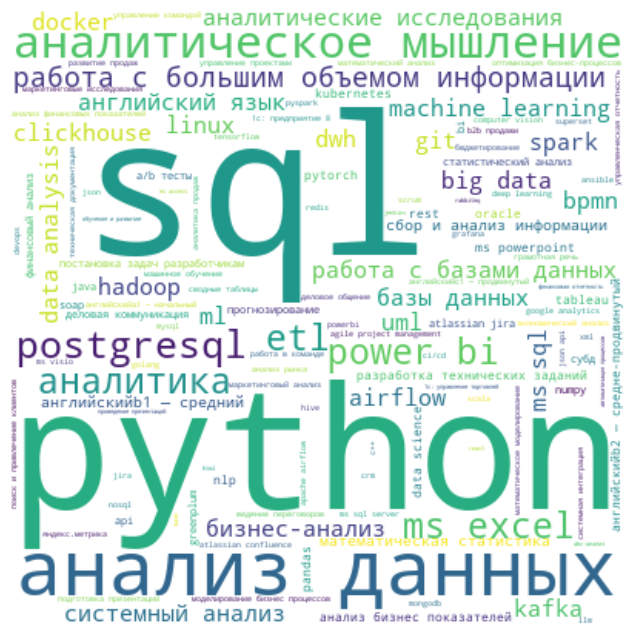

In [275]:
#построим общее облако слов тегов для вакансий 

#создаем объект WordCloud
wordcloud = WordCloud(width = 400, height = 400, background_color ='white').generate_from_frequencies(sorted_tags_counter)

#строим облако
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [276]:
#посмотрим первые 100 самых популярных тегов
for i, (tag, count) in enumerate(sorted_tags_counter.items()):
    if i < 100:
        print(f"{tag}: {count}")
    else:
        break

sql: 789
python: 708
анализ данных: 301
аналитическое мышление: 261
postgresql: 180
etl: 155
ms excel: 152
аналитика: 147
power bi: 146
работа с большим объемом информации: 140
работа с базами данных: 130
системный анализ: 128
linux: 123
clickhouse: 120
bpmn: 119
data analysis: 117
английский язык: 117
dwh: 116
базы данных: 114
бизнес-анализ: 109
ml: 108
big data: 105
git: 102
ms sql: 100
uml: 97
machine learning: 94
spark: 92
airflow: 92
hadoop: 92
docker: 90
kafka: 86
аналитические исследования: 85
сбор и анализ информации: 79
математическая статистика: 75
английскийb1 — средний: 74
разработка технических заданий: 71
английскийb2 — средне-продвинутый: 71
rest: 69
kubernetes: 64
ms powerpoint: 61
анализ бизнес показателей: 58
tableau: 58
data science: 57
pandas: 56
oracle: 54
pytorch: 53
nlp: 53
постановка задач разработчикам: 52
atlassian jira: 51
a/b тесты: 51
java: 51
greenplum: 49
статистический анализ: 49
api: 48
прогнозирование: 46
numpy: 44
bi: 43
soap: 43
финансовый анализ: 42

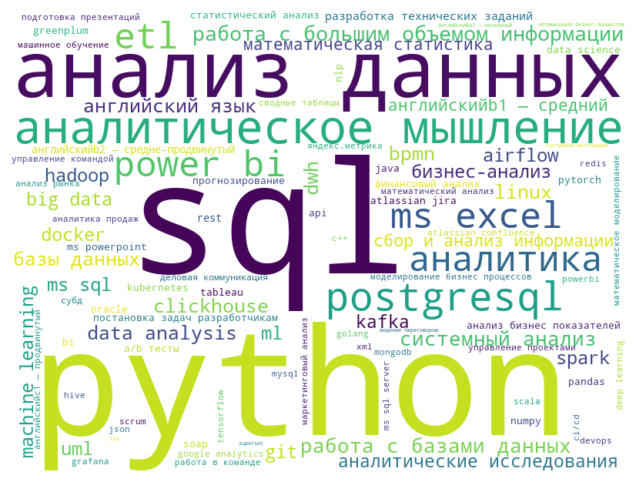

In [277]:
#сохраним эти данные 
# Выбор только 10 самых частых слов
top_100_tags = dict(list(sorted_tags_counter.items())[:100])

# Создание облака слов
wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(top_100_tags)

# Отображение облака слов
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Сохранение облака слов в файл
wordcloud.to_file(r'C:\Data\Pet Parser HH\wordcloud_top_100.png')

In [278]:
#создадим датафрейм с 50 популярными тегами для дальнейшей работы
top_tags = list(sorted_tags_counter.keys())[:50]
df_tags = pd.DataFrame(columns=top_tags)

#для каждого тега проверяем его наличие в колонке 'tags' и заполняем соответствующую колонку в df_tags
for tag in top_tags:
    df_tags[tag] = df_2['tags'].str.contains(tag, na=False).astype(int)

# обьединение датафреймов в один
df_2_with_tags = pd.concat([df_2, df_tags], axis=1)

#проверка результата
df_2_with_tags.shape


(2588, 60)

In [279]:
df_2_with_tags.sample(2)

field  salary experience                           time  \
1307    Data Analyst     0.0    3–6 лет  Полная занятость, полный день   
1889  Data Scientist     0.0    3–6 лет  Полная занятость, полный день   

                                    company          address  \
1307  ООО HeadHunter::Продуктовые аналитики           Москва   
1889                                   2ГИС  Санкт-Петербург   

                                                   tags  \
1307  sql tableau python hadoop analytics / ds mathe...   
1889          python etl machine learning data analysis   

                                                   name          job type  \
1307  middlesenior продуктовый аналитик в направлени...  полная занятость   
1889                                     data scientist  полная занятость   

        job hours  ...  анализ бизнес показателей  tableau  data science  \
1307  полный день  ...                          0        1             0   
1889  полный день  ...                          0        0             0   

      pandas  oracle  pytorch  nlp  постановка задач разработчикам  \
1307       0       0        0    0                               0   
1889       0       0        0    0                               0   

      atlassian jira  a/b тесты  
1307               0          0  
1889               0          0  

[2 rows x 60 columns]

In [280]:
#удаляем лишние колонки и сохраняем готовый для анализа датасет
df_2_with_tags= df_2_with_tags.drop(['time', 'name'], axis=1)
df_2_with_tags.to_csv(r'C:\Data\Pet Parser HH\df_2_with_tags.csv')